In [112]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')

In [88]:
# Hyperparameters
LEARNING_RATE = 0.1
DISCOUNT = 0.95
RUNS = 10000
SHOW_EVERY = 2000
UPDATE_EVERY = 100

In [89]:
# Exploration settings
epsilon = 1
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = RUNS // 2
epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)


def create_bins_and_q_table():
    num_bins = 20
    obs_space_size = len(env.observation_space.high)
    bins = [
        np.linspace(-4.8, 4.8, num_bins),
        np.linspace(-4, 4, num_bins),
        np.linspace(-0.418, 0.418, num_bins),
        np.linspace(-4, 4, num_bins)
    ]
    q_table = np.random.uniform(low=-2, high=0, size=(num_bins, num_bins, num_bins, num_bins, env.action_space.n))
    return bins, obs_space_size, q_table


In [90]:
def get_discrete_state(state, bins, obs_space_size):
    discrete_state = []
    for i in range(obs_space_size):
        discrete_state.append(np.digitize(state[i], bins[i]) - 1)
    return tuple(discrete_state)



In [91]:
bins, obs_space_size, q_table = create_bins_and_q_table()

previous_scores = []
metrics = {'ep': [], 'avg': [], 'min': [], 'max': []}

for run in range(RUNS):
    discrete_state = get_discrete_state(env.reset(), bins, obs_space_size)
    done = False
    score = 0

In [106]:
while not done:
    if run % SHOW_EVERY == 0:
        env.render()

    score += 1

    # Exploration vs Exploitation
    if np.random.random() > epsilon:
        action = np.argmax(q_table[discrete_state])
    else:
        action = env.action_space.sample()

    new_state, reward, done, _ = env.step(action)
    new_discrete_state = get_discrete_state(new_state, bins, obs_space_size)

    # Update Q-table
    max_future_q = np.max(q_table[new_discrete_state])
    current_q = q_table[discrete_state + (action,)]
    new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
    q_table[discrete_state + (action,)] = new_q

    discrete_state = new_discrete_state

    previous_scores.append(score)

    # Epsilon decay
    if END_EPSILON_DECAYING >= run >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value

    # Update metrics
    if run % UPDATE_EVERY == 0:
        latest_scores = previous_scores[-UPDATE_EVERY:]
        avg_score = sum(latest_scores) / len(latest_scores)
        metrics['ep'].append(run)
        metrics['avg'].append(avg_score)
        metrics['min'].append(min(latest_scores))
        metrics['max'].append(max(latest_scores))
        print("Run:", run, "Average Score:", avg_score, "Min Score:", min(latest_scores), "Max Score:", max(latest_scores))


In [107]:
env.close()


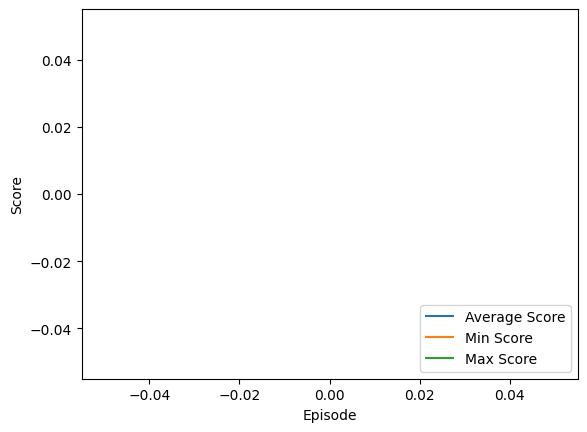

In [110]:
# Plot metrics
plt.plot(metrics['ep'], metrics['avg'], label="Average Score")
plt.plot(metrics['ep'], metrics['min'], label="Min Score")
plt.plot(metrics['ep'], metrics['max'], label="Max Score")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend(loc="lower right")
plt.show()